In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import csv
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
# Read in full Motor Vehicle Collision Dataset
mvc_df = pd.read_csv('../Motor_Vehicle_Collisions_-_Crashes.csv')

C:\Users\nedko\AppData\Local\Temp\ipykernel_26956\2128298912.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  mvc_df = pd.read_csv('../Motor_Vehicle_Collisions_-_Crashes.csv')


# NYC Collision Data Analysis
- 2,026,647 total Rows
- 22 total Columns
- Data from 2012 to 2023 (incomplete)


### MVC Columns
'CRASH DATE',  
'CRASH TIME',  
'BOROUGH',  
'NUMBER OF PERSONS INJURED',  
'NUMBER OF PERSONS KILLED',  
'NUMBER OF PEDESTRIANS INJURED',  
'NUMBER OF PEDESTRIANS KILLED',  
'NUMBER OF CYCLIST INJURED',  
'NUMBER OF CYCLIST KILLED',  
'NUMBER OF MOTORIST INJURED',  
'NUMBER OF MOTORIST KILLED',  
'CONTRIBUTING FACTOR VEHICLE 1',  
'CONTRIBUTING FACTOR VEHICLE 2',  
'CONTRIBUTING FACTOR VEHICLE 3',  
'CONTRIBUTING FACTOR VEHICLE 4',  
'CONTRIBUTING FACTOR VEHICLE 5',  
'COLLISION_ID',  
'VEHICLE TYPE CODE 1',  
'VEHICLE TYPE CODE 2',  
'VEHICLE TYPE CODE 3',  
'VEHICLE TYPE CODE 4',  
'VEHICLE TYPE CODE 5'



In [5]:
# Cleanup dataset
mvc_df['NUMBER OF PERSONS INJURED'].fillna(0, inplace=True)
mvc_df['NUMBER OF PERSONS KILLED'].fillna(0, inplace=True)

# Drop Location Columns
mvc_df.drop(['ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME'], axis=1, inplace=True)

# Add Column identifying YEAR
mvc_df['YEAR'] = mvc_df['CRASH DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)

# Limit data to the last 5 years
mvc_df = mvc_df[mvc_df['YEAR'] > 2017]
mvc_df['YEAR'].value_counts()

2018    231564
2019    211486
2020    112916
2021    110548
2022    103870
2023     67413
Name: YEAR, dtype: int64

In [6]:
injuries_df = mvc_df[mvc_df['NUMBER OF PERSONS INJURED'] > 0]
len(injuries_df)   # 453,579


229545

In [8]:
grouped_injuries = injuries_df.groupby('CONTRIBUTING FACTOR VEHICLE 1')['NUMBER OF PERSONS INJURED'].sum()

grouped_injuries.sort_values(ascending=False).head(10)

CONTRIBUTING FACTOR VEHICLE 1
Driver Inattention/Distraction    79857.0
Unspecified                       56764.0
Failure to Yield Right-of-Way     34099.0
Following Too Closely             28310.0
Traffic Control Disregarded       13877.0
Unsafe Speed                      13818.0
Passing or Lane Usage Improper     8355.0
Other Vehicular                    8270.0
Unsafe Lane Changing               6115.0
Turning Improperly                 6065.0
Name: NUMBER OF PERSONS INJURED, dtype: float64

In [9]:
fatalities_df = mvc_df[mvc_df['NUMBER OF PERSONS KILLED'] > 0]



In [ ]:
# Classify Cause
def find_cause(cause1, cause2, cause3, cause4, cause5):
    result = ''
    if('alcohol' in cause1.lower() or 'alcohol' in cause2.lower() or 'alcohol' in cause3.lower() or 'alcohol' in cause4.lower() or 'alcohol' in cause5.lower()):
        result += 'Drunk Driving,'
    if('speed' in cause1.lower() or 'speed' in cause2.lower() or 'speed' in cause3.lower() or 'speed' in cause4.lower() or 'speed' in cause5.lower()):
        result += 'Speeding,'
    if('drugs' in cause1.lower() or 'drugs' in cause2.lower() or 'drugs' in cause3.lower() or 'drugs' in cause4.lower() or 'drugs' in cause5.lower()):
        result +='Drugged Driving,'
    if('phone' in cause1.lower() or 'phone' in cause2.lower() or 'phone' in cause3.lower() or 'phone' in cause4.lower() or 'phone' in cause5.lower()):
        result +='Cell Phone Usage,'
    if('texting' in cause1.lower() or 'texting' in cause2.lower() or 'texting' in cause3.lower() or 'texting' in cause4.lower() or 'texting' in cause5.lower()):
        result += 'Cell Phone Usage,'
    if('inattention' in cause1.lower() or 'inattention' in cause2.lower() or 'inattention' in cause3.lower() or 'inattention' in cause4.lower() or 'inattention' in cause5.lower()):
        result +='Distracted Driving,'
    if(len(result) > 0):
        return result[:-1]
    else:
        return "Other"
    
def concat_causes(cause1, cause2, cause3, cause4, cause5):
    result = ''
    if (pd.isna(cause1) == False):
        result+=cause1 + ','
    if pd.isna(cause2) == False:
        result+=cause2 + ','
    if pd.isna(cause3) == False:
        result+=cause3 + ','
    if pd.isna(cause4) == False:
        result+=cause4 + ','
    if pd.isna(cause5) == False:
        result+=cause5 + ','
    return result[:-1]

injuries_df['Causes'] = injuries_df.apply(lambda x: find_cause(str(x['CONTRIBUTING FACTOR VEHICLE 1']),
                                               str(x['CONTRIBUTING FACTOR VEHICLE 2']),
                                                str(x['CONTRIBUTING FACTOR VEHICLE 3']),
                                                str(x['CONTRIBUTING FACTOR VEHICLE 4']),
                                                str(x['CONTRIBUTING FACTOR VEHICLE 5'])), axis=1)
grouped_injuries = injuries_df.groupby(['Causes', 'YEAR'])['NUMBER OF PERSONS INJURED'].sum()

grouped_injuries.sort_values(ascending=False).head(50)

In [85]:
# Sum people that were injured or killed 
mvc_df['Hurt Or Killed'] = mvc_df.apply(lambda x: 1 if (x['NUMBER OF PERSONS INJURED'] > 0 or x['NUMBER OF PERSONS KILLED'] > 0) else 0, axis=1)


## TODO - Reconstruct joined data as a contingency table with rows as factors, and accident counts w/ or w/o accidents and total count as columns##

# Get Count by Contributing Factor Vehicle 1
prop_df = mvc_df.groupby(['CONTRIBUTING FACTOR VEHICLE 1', 'Hurt Or Killed'])['COLLISION_ID'].count()
# Reset index so type is dataframe
prop_df = prop_df.reset_index()

# Get Total number of collisions by contributing factor
total_nums_df = mvc_df.groupby(['CONTRIBUTING FACTOR VEHICLE 1'])['COLLISION_ID'].count()
# Reset index to type is dataframe
total_nums_df = total_nums_df.reset_index()

# Join Dataframes
joined_df = prop_df.merge(total_nums_df, on='CONTRIBUTING FACTOR VEHICLE 1', how="left")

# Rename columns and cleanup dataset
joined_df = joined_df.rename(columns={'COLLISION_ID_x': 'COUNT IMPACTED', 'COLLISION_ID_y': 'FACTOR TOTAL'})
joined_df.drop('index', axis=1, inplace=True)

# Calculate the proportion of accidents without injury/fatality vs. those with injury/fatality
joined_df['PROP Impacted'] = joined_df['COUNT IMPACTED'] / joined_df['FACTOR TOTAL']

# Output csv for Analysis
joined_df.to_csv('joined_impact_ratio.csv')

,CRASH DATE,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,...,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,year,Hurt Or Killed
0,09/11/2021,2:39,NaN,2.0,0.0,0,0,0,0,2,...,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN,2021,1
1,03/26/2022,11:45,NaN,1.0,0.0,0,0,0,0,1,...,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN,2022,1
2,06/29/2022,6:55,NaN,0.0,0.0,0,0,0,0,0,...,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN,2022,0
3,09/11/2021,9:35,BROOKLYN,0.0,0.0,0,0,0,0,0,...,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN,2021,0
4,12/14/2021,8:13,BROOKLYN,0.0,0.0,0,0,0,0,0,...,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN,2021,0


## Analysis of Contributing Factors 
Analysis based on joined_impact_ratio.csv file
- Pedestrian/Bicyclist/Other Pedestrian Error/Confusion is the most deadly (75% of them result in injuries or fatalities).
- Failure to Yield Right-of-Way has a the highest injury/fatality ratio based on total accident count (39% for 47,007 accidents)

In [122]:
unspecified_df = mvc_df[mvc_df['CONTRIBUTING FACTOR VEHICLE 1'] == 'Unspecified']

,CRASH DATE,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,...,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,year,Hurt Or Killed
3,09/11/2021,9:35,BROOKLYN,0.0,0.0,0,0,0,0,0,...,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN,2021,0
5,04/14/2021,12:47,NaN,0.0,0.0,0,0,0,0,0,...,NaN,NaN,4407458,Dump,Sedan,NaN,NaN,NaN,2021,0
7,12/14/2021,8:17,BRONX,2.0,0.0,0,0,0,0,2,...,NaN,NaN,4486660,Sedan,Sedan,NaN,NaN,NaN,2021,1
18,12/11/2021,19:43,BRONX,1.0,0.0,0,0,0,0,1,...,NaN,NaN,4487040,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,2021,1
22,12/13/2021,6:30,QUEENS,0.0,0.0,0,0,0,0,0,...,NaN,NaN,4486967,Sedan,NaN,NaN,NaN,NaN,2021,0


In [123]:
len(unspecified_df)

694778

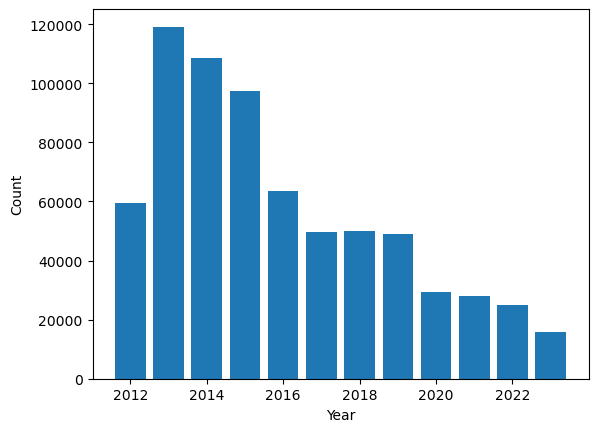

In [127]:
count_by_year = unspecified_df['year'].value_counts()
count_by_year.head()

plt.bar(count_by_year.index, count_by_year.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [155]:
from scipy.stats import pointbiserialr

# Sample correlation
sample_df = mvc_df.sample(frac=0.10)


sample_df['C1'] = sample_df.apply(lambda x: 1 if x['CONTRIBUTING FACTOR VEHICLE 1'] == 'Backing Unsafely' else 0, axis=1)
print('Injury Correlation: ', pointbiserialr(sample_df['C1'], sample_df['NUMBER OF PERSONS INJURED']))
print('Fatality Correlation: ', pointbiserialr(sample_df['C1'], sample_df['NUMBER OF PERSONS KILLED']))


Injury Correlation:  SignificanceResult(statistic=-0.054240636421845526, pvalue=7.078371832299977e-132)
Fatality Correlation:  SignificanceResult(statistic=-0.0033896931929920807, pvalue=0.12701528738647216)


In [149]:
from scipy.stats import pointbiserialr
sample_df['C1'] = sample_df.apply(lambda x: 1 if x['CONTRIBUTING FACTOR VEHICLE 1'] == 'Unsafe Speed' else 0, axis=1)
print('Injury Correlation: ', pointbiserialr(sample_df['C1'], sample_df['NUMBER OF PERSONS INJURED']))
print('Fatality Correlation: ', pointbiserialr(sample_df['C1'], sample_df['NUMBER OF PERSONS KILLED']))

Injury Correlation:  SignificanceResult(statistic=0.06769725694184842, pvalue=1.8629084276948565e-204)
Fatality Correlation:  SignificanceResult(statistic=0.006593775391769506, pvalue=0.002993335532044906)


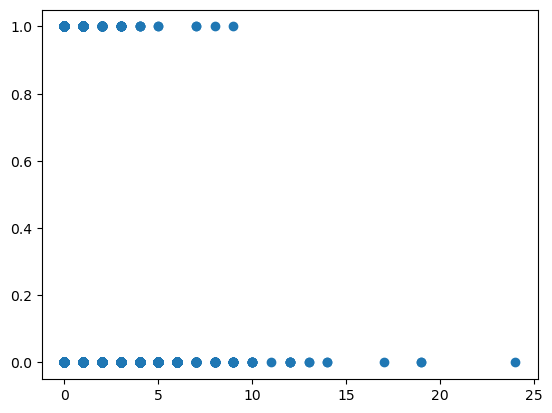

In [156]:
plt.scatter(sample_df['NUMBER OF PERSONS INJURED'], sample_df['C1'])
plt.show()

In [175]:
def find_injury_corr_value(factor, df):
    factor_encoded = df.apply(lambda x: 1 if x['CONTRIBUTING FACTOR VEHICLE 1'] == factor else 0, axis=1)
    return pointbiserialr(factor_encoded, df['NUMBER OF PERSONS INJURED'])


factor_list = mvc_df['CONTRIBUTING FACTOR VEHICLE 1'].unique()
# Sample correlation
sample_df = mvc_df.sample(frac=0.01)

result = []
for value in factor_list:
    injury_corr = find_injury_corr_value(value, sample_df)
    result.append((value, injury_corr[0]))
    
result

C:\Users\nedko\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\nedko\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\nedko\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\nedko\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\nedko\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the corr

[('Aggressive Driving/Road Rage', 0.008365767126866906),
 ('Pavement Slippery', 0.004017074347154984),
 ('Following Too Closely', 0.024798005796617777),
 ('Unspecified', -0.045407649158267366),
 (nan, nan),
 ('Passing Too Closely', -0.0558725575188585),
 ('Driver Inexperience', 0.0017239536388759763),
 ('Passing or Lane Usage Improper', -0.03324039924186549),
 ('Turning Improperly', -0.028299727829156924),
 ('Unsafe Lane Changing', -0.009688239156348935),
 ('Unsafe Speed', 0.05857482816136779),
 ('Reaction to Uninvolved Vehicle', 0.0022138498306994644),
 ('Steering Failure', -0.001299202670968923),
 ('Traffic Control Disregarded', 0.07645188892917418),
 ('Other Vehicular', -0.00734471197845341),
 ('Driver Inattention/Distraction', 0.01143545242864705),
 ('Oversized Vehicle', -0.031740107942619916),
 ('Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
  0.06319864196067139),
 ('Alcohol Involvement', 0.034136635168245506),
 ('View Obstructed/Limited', 0.0005083722147156463),
 ('Fai

In [162]:
result_df = pd.DataFrame()
result_df

""


In [168]:
factor_list = mvc_df['CONTRIBUTING FACTOR VEHICLE 1'].unique()

factor_list

array(['Aggressive Driving/Road Rage', 'Pavement Slippery',
       'Following Too Closely', 'Unspecified', nan, 'Passing Too Closely',
       'Driver Inexperience', 'Passing or Lane Usage Improper',
       'Turning Improperly', 'Unsafe Lane Changing', 'Unsafe Speed',
       'Reaction to Uninvolved Vehicle', 'Steering Failure',
       'Traffic Control Disregarded', 'Other Vehicular',
       'Driver Inattention/Distraction', 'Oversized Vehicle',
       'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
       'Alcohol Involvement', 'View Obstructed/Limited',
       'Failure to Yield Right-of-Way', 'Illnes', 'Lost Consciousness',
       'Brakes Defective', 'Backing Unsafely', 'Glare',
       'Passenger Distraction', 'Fell Asleep', 'Obstruction/Debris',
       'Tinted Windows', 'Animals Action', 'Drugs (illegal)',
       'Pavement Defective', 'Other Lighting Defects',
       'Outside Car Distraction', 'Driverless/Runaway Vehicle',
       'Tire Failure/Inadequate', 'Fatigued/Drowsy',
